In [3]:
from pandas import read_csv
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
##################################################
# Question a
##################################################

# location of file
filename = 'C:/Users/fabio/Desktop/Online Retail.csv'

# Load the data with limited rows for faster processing
dataset = read_csv(filename, encoding='windows-1254')

# Display the first few rows to understand the dataset
print(dataset.head(), "\n")

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom   



In [5]:
# Data preprocessing: adding a TotalPrice column
dataset['TotalPrice'] = dataset['Quantity'] * dataset['UnitPrice']

# Aggregating the data by CustomerID to get the total quantity and total price for each customer
customer_data = dataset.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index()

# Feature scaling
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(customer_data[['Quantity', 'TotalPrice']])


# Function to calculate silhouette scores for k-means with clusters between 2 and 8
silhouette_scores = []
range_n_clusters = range(2, 9)

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_dataset)
    silhouette_avg = silhouette_score(scaled_dataset, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
# Silhouette scores for k-means with clusters between 2 and 8
print("Silhouette_scores:", silhouette_scores)

Silhouette_scores: [np.float64(0.9830044706552725), np.float64(0.9561031477840037), np.float64(0.9314275129237506), np.float64(0.8155049239902049), np.float64(0.8054488993304987), np.float64(0.7187161900187621), np.float64(0.7186826301815898)]


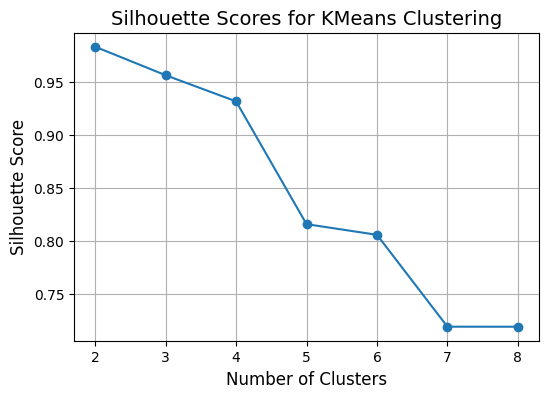

In [6]:
# Plotting the silhouette scores
plt.figure(figsize=(6, 4))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for KMeans Clustering', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True)
plt.show()

In [7]:
# Determine the 2 best values for the number of clusters
best_clusters = np.argsort(silhouette_scores)[-2:] + 2  # Adding 2 because of 0-indexing
print("The best two clusters are", best_clusters)

The best two clusters are [3 2]


In [8]:
##################################################
# Question b
##################################################

# Function for plotting the centroids for the clusters
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)
    
# Function for plotting the Voronoi diagram for the clusters
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

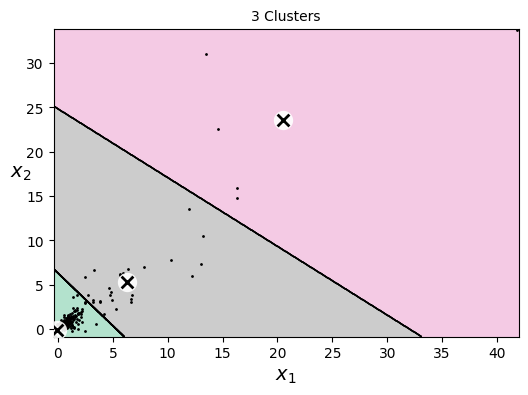

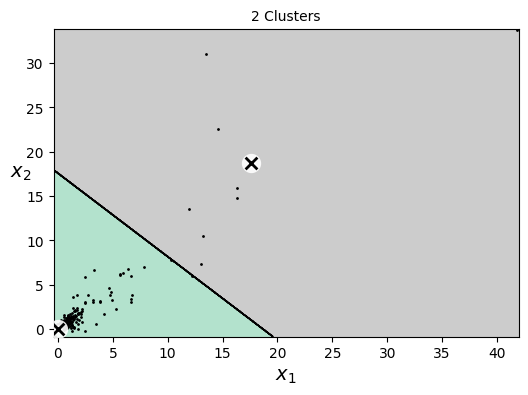

In [9]:
# Function for plotting the best two clusters
for i in best_clusters:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit_predict(scaled_dataset)
    kmeans.cluster_centers_
    plt.figure(figsize=(6, 4))
    plot_decision_boundaries(kmeans, scaled_dataset)
    title = str(i) + ' Clusters'
    plt.title(title, fontsize=10)
    plt.show()

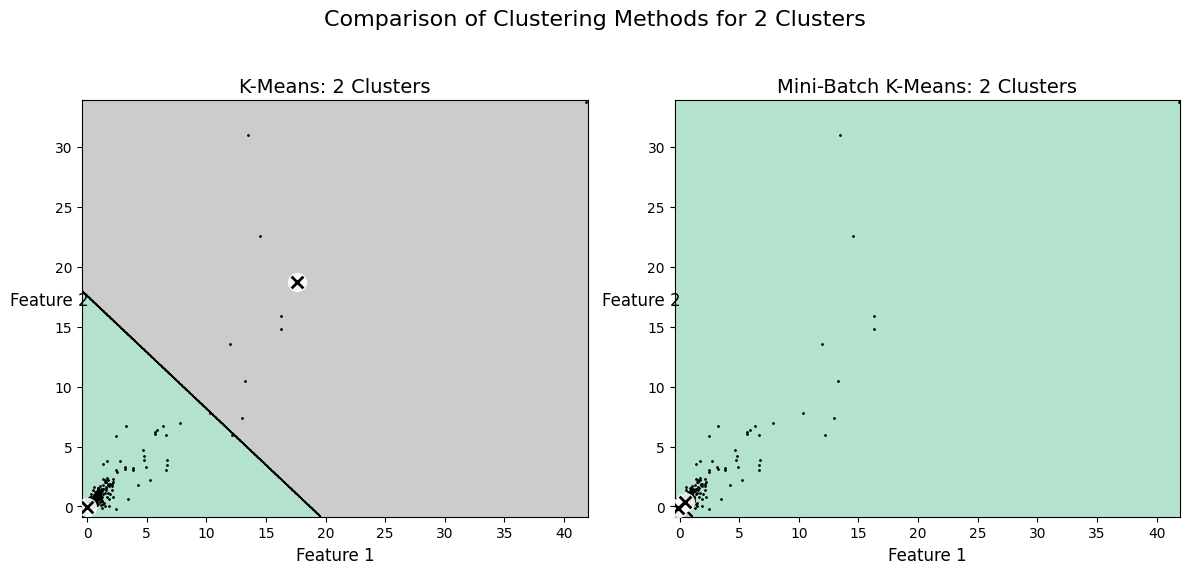

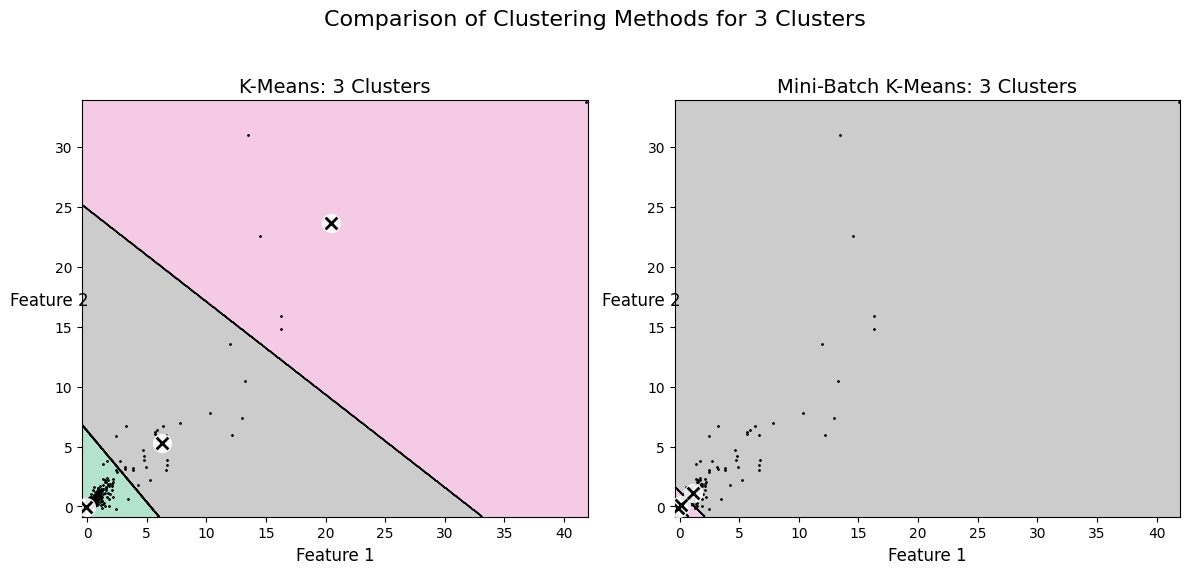

In [45]:
from sklearn.cluster import MiniBatchKMeans

# Part c: Mini-Batch K-Means Implementation
mini_batch_size = 200
best_two_clusters = [2, 3]

for i in best_two_clusters:
    # K-Means
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit_predict(scaled_dataset)
    
    # Mini-Batch K-Means
    mini_kmeans = MiniBatchKMeans(n_clusters=i, batch_size=mini_batch_size, random_state=42)
    mini_kmeans.fit_predict(scaled_dataset)
    
    plt.figure(figsize=(12, 6))

    # Plot K-Means
    plt.subplot(1, 2, 1)
    plot_decision_boundaries(kmeans, scaled_dataset)
    plt.title(f'K-Means: {i} Clusters', fontsize=14)
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)

    # Plot Mini-Batch K-Means
    plt.subplot(1, 2, 2)
    plot_decision_boundaries(mini_kmeans, scaled_dataset)
    plt.title(f'Mini-Batch K-Means: {i} Clusters', fontsize=14)
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)

    plt.suptitle(f'Comparison of Clustering Methods for {i} Clusters', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
    plt.show()


C:\Users\fabio\AppData\Local\Temp\ipykernel_26188\194832632.py:42: RankWarning: Polyfit may be poorly conditioned
  kmeans_inertia_fit = np.polyfit(best_n_clusters, kmeans_inertia, deg=2)
C:\Users\fabio\AppData\Local\Temp\ipykernel_26188\194832632.py:43: RankWarning: Polyfit may be poorly conditioned
  mini_batch_inertia_fit = np.polyfit(best_n_clusters, mini_batch_inertia, deg=2)
C:\Users\fabio\AppData\Local\Temp\ipykernel_26188\194832632.py:46: RankWarning: Polyfit may be poorly conditioned
  kmeans_time_fit = np.polyfit(best_n_clusters, kmeans_time, deg=2)
C:\Users\fabio\AppData\Local\Temp\ipykernel_26188\194832632.py:47: RankWarning: Polyfit may be poorly conditioned
  mini_batch_time_fit = np.polyfit(best_n_clusters, mini_batch_time, deg=2)


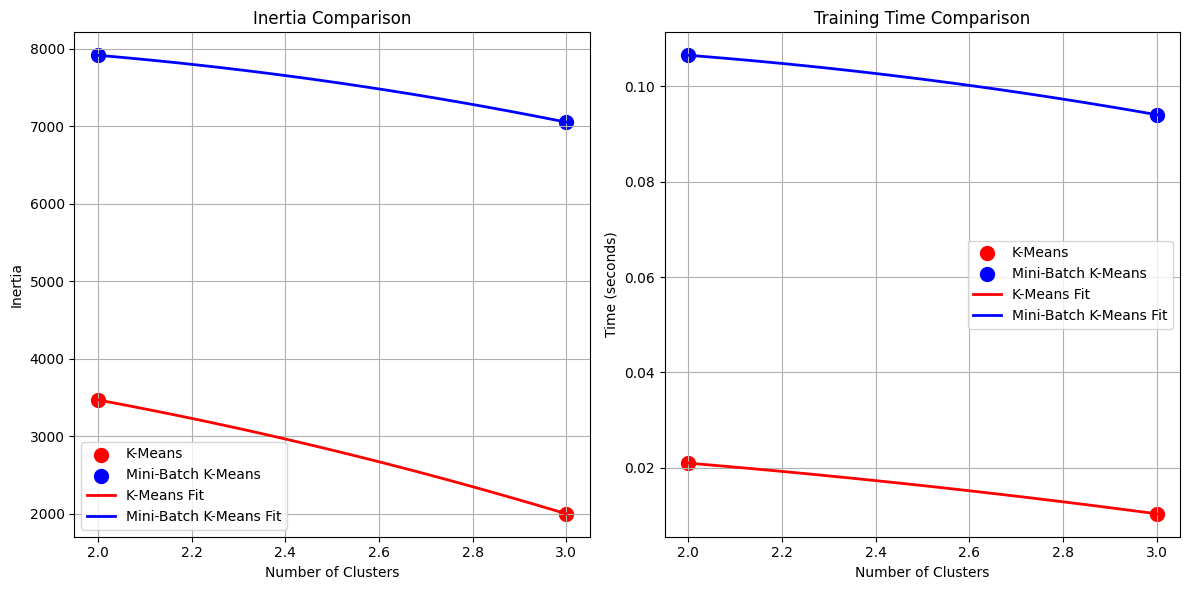

In [49]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import time
import matplotlib.pyplot as plt

# Define the best cluster numbers from part a
best_n_clusters = [2, 3]  # Replace these with the best values you determined

# Define the mini-batch size
mini_batch_size = 200  # Adjust this based on your dataset size

# Lists to hold inertia and training times
kmeans_inertia = []
mini_batch_inertia = []
kmeans_time = []
mini_batch_time = []

# Calculate Inertia and Training time for K-Means and Mini-Batch K-Means
for n_clusters in best_n_clusters:
    # K-Means
    start_time = time.time()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_dataset)
    kmeans_inertia.append(kmeans.inertia_)
    kmeans_time.append(time.time() - start_time)

    # Mini-Batch K-Means
    start_time = time.time()
    mini_batch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=mini_batch_size, random_state=42)
    mini_batch_kmeans.fit(scaled_dataset)
    mini_batch_inertia.append(mini_batch_kmeans.inertia_)
    mini_batch_time.append(time.time() - start_time)

# Convert lists to numpy arrays for fitting
best_n_clusters = np.array(best_n_clusters)
kmeans_inertia = np.array(kmeans_inertia)
mini_batch_inertia = np.array(mini_batch_inertia)
kmeans_time = np.array(kmeans_time)
mini_batch_time = np.array(mini_batch_time)

# Fit a polynomial line to the inertia data
kmeans_inertia_fit = np.polyfit(best_n_clusters, kmeans_inertia, deg=2)
mini_batch_inertia_fit = np.polyfit(best_n_clusters, mini_batch_inertia, deg=2)

# Fit a polynomial line to the training time data
kmeans_time_fit = np.polyfit(best_n_clusters, kmeans_time, deg=2)
mini_batch_time_fit = np.polyfit(best_n_clusters, mini_batch_time, deg=2)

# Create a smooth line using the fitted polynomial
x_fit = np.linspace(best_n_clusters.min(), best_n_clusters.max(), 100)
kmeans_inertia_line = np.polyval(kmeans_inertia_fit, x_fit)
mini_batch_inertia_line = np.polyval(mini_batch_inertia_fit, x_fit)

kmeans_time_line = np.polyval(kmeans_time_fit, x_fit)
mini_batch_time_line = np.polyval(mini_batch_time_fit, x_fit)

# Plotting Inertia and Training Time
plt.figure(figsize=(12, 6))

# Inertia Plot
plt.subplot(1, 2, 1)
plt.scatter(best_n_clusters, kmeans_inertia, color='red', marker='o', label='K-Means', s=100)
plt.scatter(best_n_clusters, mini_batch_inertia, color='blue', marker='o', label='Mini-Batch K-Means', s=100)
plt.plot(x_fit, kmeans_inertia_line, color='red', linewidth=2, label='K-Means Fit')
plt.plot(x_fit, mini_batch_inertia_line, color='blue', linewidth=2, label='Mini-Batch K-Means Fit')
plt.title('Inertia Comparison')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.legend()
plt.grid()

# Training Time Plot
plt.subplot(1, 2, 2)
plt.scatter(best_n_clusters, kmeans_time, color='red', marker='o', label='K-Means', s=100)
plt.scatter(best_n_clusters, mini_batch_time, color='blue', marker='o', label='Mini-Batch K-Means', s=100)
plt.plot(x_fit, kmeans_time_line, color='red', linewidth=2, label='K-Means Fit')
plt.plot(x_fit, mini_batch_time_line, color='blue', linewidth=2, label='Mini-Batch K-Means Fit')
plt.title('Training Time Comparison')
plt.xlabel('Number of Clusters')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [50]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Function to evaluate clustering results
def evaluate_clustering(true_labels, cluster_labels, method_name):
    correlation_matrix = np.corrcoef(true_labels.T)
    ch_index = calinski_harabasz_score(scaled_dataset, cluster_labels)
    db_index = davies_bouldin_score(scaled_dataset, cluster_labels)
    
    print(f"Evaluation Metrics for {method_name}:")
    print("Correlation Matrix:\n", correlation_matrix)
    print("Calinski-Harabasz Index:", ch_index)
    print("Davies-Bouldin Index:", db_index)
    print("\n")

# Evaluate K-Means and Mini-Batch K-Means for the best two clusters
for i in best_two_clusters:
    # K-Means evaluation
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans_labels = kmeans.fit_predict(scaled_dataset)
    evaluate_clustering(scaled_dataset, kmeans_labels, f'K-Means with {i} Clusters')
    
    # Mini-Batch K-Means evaluation
    mini_kmeans = MiniBatchKMeans(n_clusters=i, batch_size=mini_batch_size, random_state=42)
    mini_kmeans_labels = mini_kmeans.fit_predict(scaled_dataset)
    evaluate_clustering(scaled_dataset, mini_kmeans_labels, f'Mini-Batch K-Means with {i} Clusters')


Evaluation Metrics for K-Means with 2 Clusters:
Correlation Matrix:
 [[1.         0.92164896]
 [0.92164896 1.        ]]
Calinski-Harabasz Index: 6649.465459498878
Davies-Bouldin Index: 0.41365781175655486


Evaluation Metrics for Mini-Batch K-Means with 2 Clusters:
Correlation Matrix:
 [[1.         0.92164896]
 [0.92164896 1.        ]]
Calinski-Harabasz Index: 667.355715070368
Davies-Bouldin Index: 0.9898324745806896


Evaluation Metrics for K-Means with 3 Clusters:
Correlation Matrix:
 [[1.         0.92164896]
 [0.92164896 1.        ]]
Calinski-Harabasz Index: 7372.881342197374
Davies-Bouldin Index: 0.5763144742797394


Evaluation Metrics for Mini-Batch K-Means with 3 Clusters:
Correlation Matrix:
 [[1.         0.92164896]
 [0.92164896 1.        ]]
Calinski-Harabasz Index: 803.5857313442767
Davies-Bouldin Index: 1.0063116175045907


